In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

This program uses locally downloaded data sets from the "Universum" github repo.

In [4]:
eeg_data = pd.read_csv('C:/Users/Brendan/GitHubRepos/Universum/DataCollection/data/EEGdata/103/1/3/eeg_data_raw.csv')

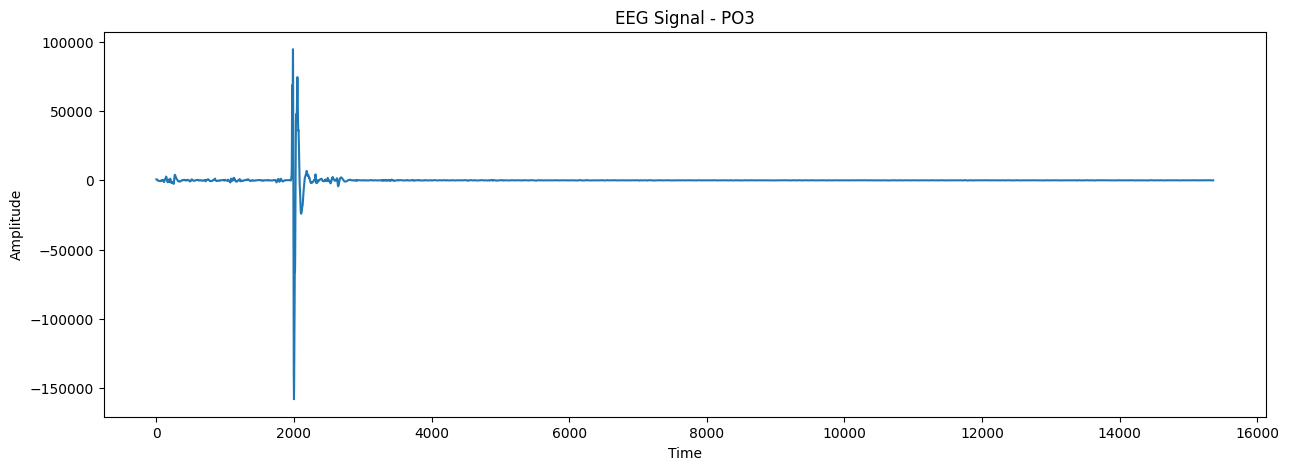

In [5]:
plt.figure(figsize=(15, 5))
plt.plot(eeg_data['PO3'])
plt.title('EEG Signal - PO3')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show() # Plots only the EEG signal of the PO3 channel

I was successfully able to display the EEG signal of the PO3 channel.

In [6]:
import mne
from mne.viz import plot_topomap
from mne.channels import make_standard_montage

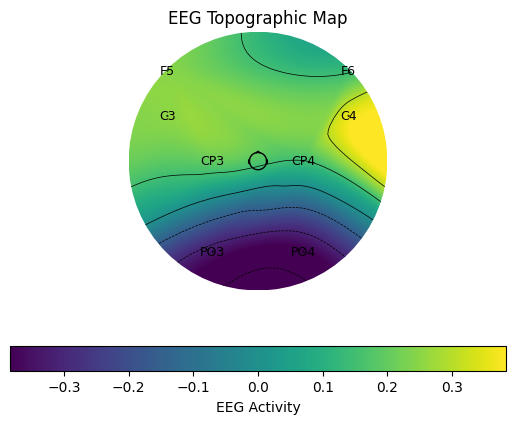

In [7]:
# Convert to NumPy and exclude timestamp
eeg_activity = eeg_data.iloc[:, 1:].values  # Exclude timestamp column

# Aggregate the data: Compute the mean across all time points
eeg_snapshot = eeg_activity.mean(axis=0)  # Shape: (8,)

# Define positions for the 8 EEG channels
positions = np.array([
    [-0.5, 0],   # CP3
    [-1, 0.5],   # C3
    [-1, 1],     # F5
    [-0.5, -1],  # PO3
    [0.5, -1],   # PO4
    [1, 1],      # F6
    [1, 0.5],    # C4
    [0.5, 0]     # CP4
])

# Define channel names
channel_names = ['CP3', 'C3', 'F5', 'PO3', 'PO4', 'F6', 'C4', 'CP4']

# Create the plot
fig, ax = plt.subplots()

# Plot the topomap for the 8 channels
im, _ = plot_topomap(eeg_snapshot, positions, axes=ax, show=False, cmap='viridis')

# Add channel names manually
for pos, name in zip(positions, channel_names):
    ax.text(pos[0], pos[1], name, fontsize=9, ha='center', va='center', color='black')

# Add a colorbar
plt.colorbar(im, ax=ax, orientation='horizontal', label="EEG Activity")
plt.title("EEG Topographic Map")
plt.show()

I was able to visualize some EEG data. The next steps are to quality check, handle artifacts, and format the data for training by Whitening the EEG Data Using PCA.

In [8]:
print(eeg_data.isnull().sum()) # All zeros confirms there are no missing data or anomalies

timestamp    0
CP3          0
C3           0
F5           0
PO3          0
PO4          0
F6           0
C4           0
CP4          0
dtype: int64


In [9]:
import pandas as pd
import numpy as np

eeg_data = pd.read_csv('C:/Users/Brendan/GitHubRepos/Universum/DataCollection/data/EEGdata/103/1/3/eeg_data_raw.csv')

# Convert to numpy array for easier processing
numpy_data = eeg_data.values

In [10]:
from scipy.signal import butter, filtfilt

start_noise_indice = 100
end_noise_indice = 120

def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype="band")
    return filtfilt(b, a, data, axis=0)

fs = 256  # Sampling frequency
filtered_data = bandpass_filter(eeg_activity, lowcut=1, highcut=40, fs=fs)
signal_power = np.mean(filtered_data ** 2, axis=0)
noise_segment = eeg_activity[start_noise_indice:end_noise_indice]  # These are the start and:end for noise indices
noise_power = np.mean(noise_segment ** 2, axis=0)

Now to actually compute and display SNR using the formula:

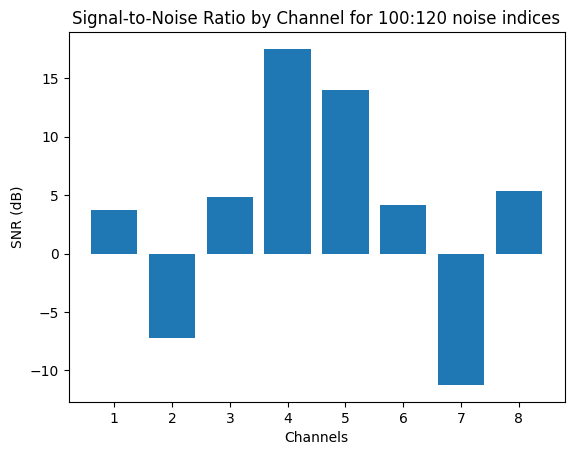

In [11]:
snr = 10 * np.log10(signal_power / noise_power)

channels = [f"{i+1}" for i in range(filtered_data.shape[1])]

plt.bar(channels, snr)
plt.xlabel("Channels")
plt.ylabel("SNR (dB)")
plt.title("Signal-to-Noise Ratio by Channel for " + str(start_noise_indice) +":" + str(end_noise_indice) + " noise indices")
plt.show()

Now that I can visualize SNL, I will try to remove line noise at 50/60 Hz using a notch filter:

In [12]:
from scipy.signal import iirnotch

def notch_filter(data, freq, fs, quality_factor=30):
    nyquist = 0.5 * fs
    freq = freq / nyquist
    b, a = iirnotch(freq, quality_factor)
    return filtfilt(b, a, data, axis=0)

filtered_data = notch_filter(filtered_data, freq=50, fs=fs)

I will set the threshold at 100 to detect eye blinks:

In [13]:
threshold = 100  # Microvolt threshold for artifacts
artifact_indices = np.where(np.abs(filtered_data) > threshold)

Next, I will try to detect abrupt, irregular changes in amplitude using a moving standard deviation::

In [14]:
window_size = int(fs * 0.5)  # 0.5-second window
motion_artifacts = np.std(filtered_data, axis=0) > np.mean(filtered_data) + 3 * np.std(filtered_data)

After detecting these artifacts, I will create a new data variable with the artifacts removed:

In [15]:
clean_eeg_activity = eeg_activity.copy()

# Iterate over each channel (column)
for channel in range(eeg_activity.shape[1]):
    # Extract the channel data
    channel_data = eeg_activity[:, channel]
    
    # Identify artifact indices for this channel
    artifact_indices = np.where(np.abs(channel_data) > threshold)[0]
    
    # Interpolate over artifact indices
    for index in artifact_indices:
        clean_eeg_activity[index, channel] = np.interp(
            index,
            np.delete(np.arange(len(channel_data)), artifact_indices),
            np.delete(channel_data, artifact_indices)
        )

In [16]:
filtered_data[:, motion_artifacts] = 0

print("Noisy channels zeroed out:", np.where(motion_artifacts)[0])

Noisy channels zeroed out: []


The array is empty, so there were no abrupt, irregular changes in amplitude detected from moving standard deviation.

In [17]:
# Define the bandpass filter
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs  # Nyquist frequency
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data, axis=0)

# Apply bandpass filter to the EEG data
lowcut = 1  # Lower frequency cutoff (Hz)
highcut = 40  # Upper frequency cutoff (Hz)
filtered_data = bandpass_filter(eeg_activity, lowcut, highcut, fs)

print("Bandpass filtering complete.")

Bandpass filtering complete.


In [18]:
from scipy.signal import iirnotch

# Define the notch filter
def notch_filter(data, freq, fs, quality_factor=30):
    nyquist = 0.5 * fs
    freq = freq / nyquist  # Normalize frequency
    b, a = iirnotch(freq, quality_factor)
    return filtfilt(b, a, data, axis=0)

# Apply notch filter to remove line noise
notch_freq = 60  # Frequency to remove (60 Hz for US)
filtered_data = notch_filter(filtered_data, notch_freq, fs)

print("Notch filtering complete.")

Notch filtering complete.


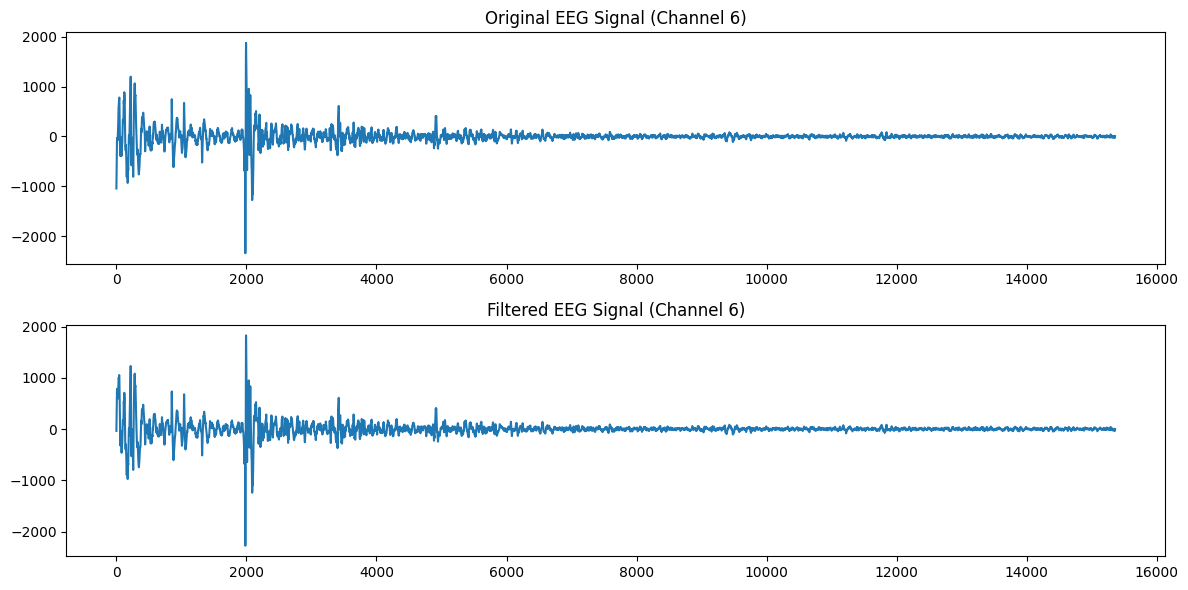

In [19]:
channel = 6  # Choose a channel to visualize

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(eeg_activity[:, channel])
plt.title("Original EEG Signal (Channel {})".format(channel))

plt.subplot(2, 1, 2)
plt.plot(filtered_data[:, channel])
plt.title("Filtered EEG Signal (Channel {})".format(channel))
plt.tight_layout()
plt.show()

EEG data quality analysis findings:

Before and after filtering looks very similar, but if you look really closely after t = 2000 there are some small differences. 

All in all, there were some artifacts revealed and cleaned using a notch filter giving reason to believe eye blinks contributed to some of the noise. Other than that, there were little to no motion artifacts or major discrepicies detected in frequency.

All of the channels seem to detect a sudden spike telling me that something must have happened (perhaps the headset was moved) at time t = 2000.

Now onto PCA Whitening. PCA requires the data to be mean-centered and scaled to unit variance:

In [20]:
from sklearn.preprocessing import StandardScaler

# Standardize data (zero mean, unit variance)
scaler = StandardScaler()
standardized_data = scaler.fit_transform(eeg_activity)

print("Standardized data shape:", standardized_data.shape)

Standardized data shape: (15360, 8)


In [21]:
from sklearn.decomposition import PCA

# Apply PCA with whitening
pca = PCA(whiten=True)
whitened_data = pca.fit_transform(standardized_data)

print("Whitened data shape:", whitened_data.shape)

Whitened data shape: (15360, 8)


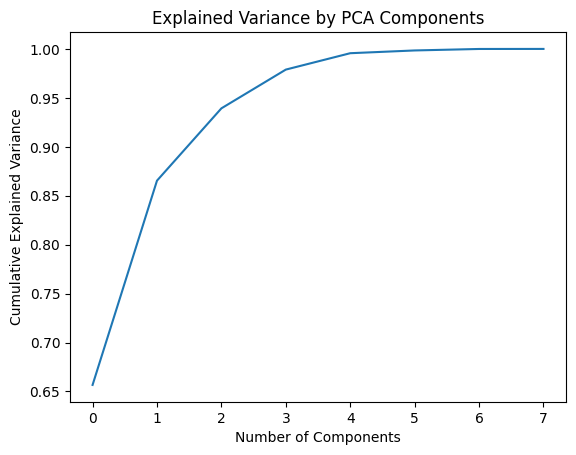

In [22]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.show()

In [23]:
# Saving whitened data for future use
np.save('eeg_data_whitened.npy', whitened_data)

Next, applying ICA:

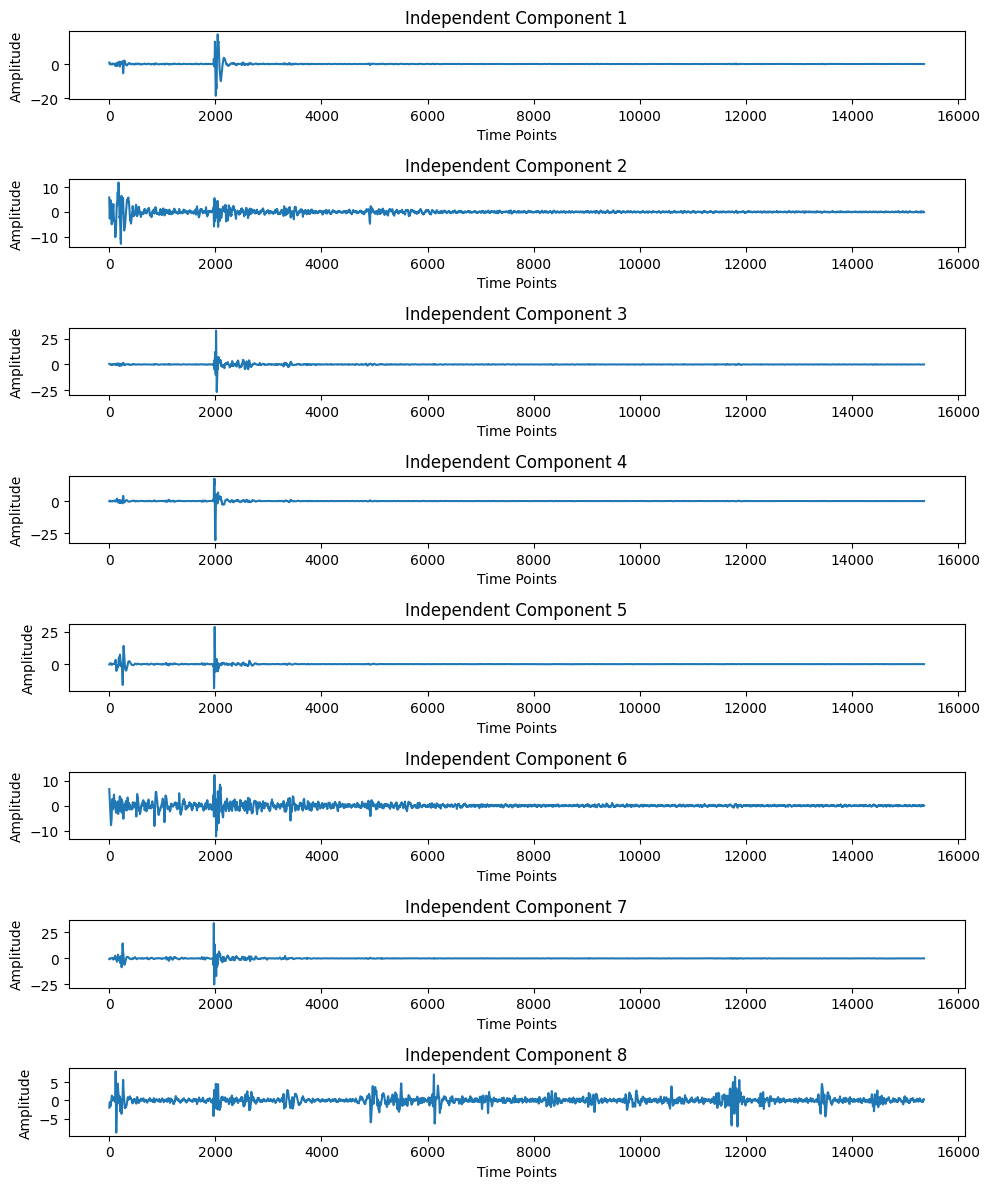

In [24]:
from sklearn.decomposition import FastICA

ica = FastICA(n_components=8, random_state=0) # Used 8 as number of components for this specific data set
eeg_data_ica = ica.fit_transform(whitened_data)
#ica.plot_components() only works for mne, I found out
plt.figure(figsize=(10, 12))
for i in range(eeg_data_ica.shape[1]):  # Iterate through ICs
    plt.subplot(eeg_data_ica.shape[1], 1, i + 1)
    plt.plot(eeg_data_ica[:, i])
    plt.title(f"Independent Component {i+1}")
    plt.xlabel("Time Points")
    plt.ylabel("Amplitude")
    plt.tight_layout()

plt.show()


In [25]:
artifact_indices = []
threshold = np.max(np.abs(eeg_data_ica), axis=0) > 25  # Adjust threshold
artifact_indices = np.where(threshold)[0]

print("Potential artifact components:", artifact_indices)

Potential artifact components: [2 3 4 6]


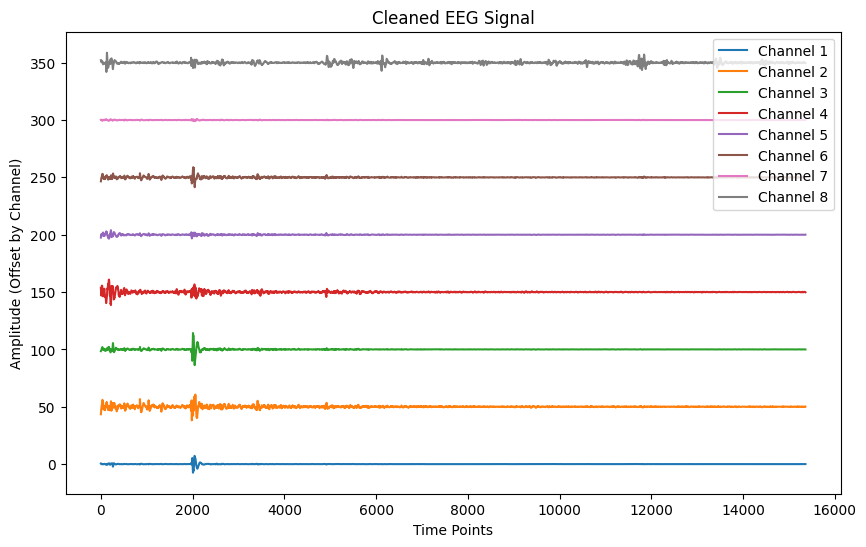

In [26]:
artifact_indices = [2, 3, 4, 6]  # Example: Exclude components 2 and 3

# Zero-out artifact components
cleaned_ica = eeg_data_ica.copy()
cleaned_ica[:, artifact_indices] = 0

# Reconstruct the signal from the remaining components
reconstructed_data = ica.inverse_transform(cleaned_ica)

# Now to plot the new data
plt.figure(figsize=(10, 6))
for i in range(reconstructed_data.shape[1]):  # Iterate through channels
    plt.plot(reconstructed_data[:, i] + i * 50, label=f"Channel {i+1}")  # Offset for visibility
plt.title("Cleaned EEG Signal")
plt.xlabel("Time Points")
plt.ylabel("Amplitude (Offset by Channel)")
plt.legend(loc="upper right")
plt.show()

# Save cleaned data to CSV
import pandas as pd
pd.DataFrame(reconstructed_data).to_csv("cleaned_eeg_activity.csv", index=False)

In [27]:
np.save('eeg_data_ica_cleaned.npy', eeg_data_ica) # Saved as a .npy file

Now that I am able to convert .csv files into cleaned .npy files, it's time to train an ML model

In [31]:
eeg_data = pd.read_csv('C:/Users/Brendan/GitHubRepos/Universum/DataCollection/data/EEGdata/103/1/3/eeg_data_raw.csv')
accel_data = pd.read_csv('C:/Users/Brendan/GitHubRepos/Universum/DataCollection/data/EEGdata/103/1/3/accelerometer_data.csv')

eeg_data['timestamp'] = pd.to_datetime(eeg_data['timestamp'])
accel_data['timestamp'] = pd.to_datetime(accel_data['timestamp'])

# Convert timestamps to numeric values for interpolation
eeg_time_numeric = eeg_data['timestamp'].astype(int) / 10**9  # Convert to seconds since epoch
accel_time_numeric = accel_data['timestamp'].astype(int) / 10**9  # Convert to seconds since epoch

In [36]:
print(accel_data.dtypes)  # Check data types for each column
print(accel_data.head())  # Look at a sample of the data

timestamp       datetime64[ns]
device_id               object
x                      float64
y                      float64
z                      float64
pitch                  float64
roll                   float64
acceleration           float64
inclination            float64
dtype: object
                timestamp                         device_id     x     y     z  \
0 2024-10-05 15:17:58.529  83c8c23779fed513bf54b2caa651454b -0.05 -0.75 -0.58   
1 2024-10-05 15:17:58.730  83c8c23779fed513bf54b2caa651454b -0.02 -0.82 -0.47   
2 2024-10-05 15:17:58.860  83c8c23779fed513bf54b2caa651454b  0.13 -0.90 -0.44   
3 2024-10-05 15:17:58.930  83c8c23779fed513bf54b2caa651454b  0.15 -0.80 -0.44   
4 2024-10-05 15:17:59.030  83c8c23779fed513bf54b2caa651454b  0.18 -0.82 -0.47   

   pitch   roll  acceleration  inclination  
0  -2.90 -52.12          0.95       -93.67  
1  -0.97 -60.15          0.94       -91.12  
2   7.29 -62.72          1.01       -81.87  
3   9.19 -59.67          0.93       -79.

In [42]:
from scipy.interpolate import interp1d

numeric_cols = accel_data.select_dtypes(include=['number']).columns

# Interpolate each accelerometer column
interp_functions = {}
for col in numeric_cols:
    interp_functions[col] = interp1d(
        accel_time_numeric,
        accel_data[col],
        kind='linear',  # Linear interpolation
        fill_value="extrapolate"
    )

# Create interpolated accelerometer data for EEG timestamps
interp_accel_data = {col: interp_functions[col](eeg_time_numeric) for col in numeric_cols}
interp_accel_df = pd.DataFrame(interp_accel_data)

# Add EEG timestamps and merge with interpolated accelerometer data
interp_accel_df['timestamp'] = eeg_data['timestamp']
merged_data = pd.concat([eeg_data.reset_index(drop=True), interp_accel_df], axis=1)

# Save or display the result
print(merged_data.head())
merged_data.to_csv('interpolated_eeg_accel_data.csv', index=False)


                timestamp         CP3          C3          F5         PO3  \
0 2024-10-05 15:17:59.368 -632.597900 -589.923396 -714.968081  719.250867   
1 2024-10-05 15:17:59.368 -591.736325 -574.698615 -663.856237  746.601373   
2 2024-10-05 15:17:59.368 -572.806800 -574.477533 -635.003315  725.909419   
3 2024-10-05 15:17:59.368 -557.204529 -580.191609 -609.167922  675.881366   
4 2024-10-05 15:17:59.368 -523.798490 -575.994042 -563.903722  622.467124   

          PO4          F6           C4         CP4         x        y  \
0  -38.903425 -875.481716 -1041.862139 -749.195760 -0.028513 -0.85446   
1  125.593989 -828.912344  -909.863577 -716.826795 -0.028513 -0.85446   
2  244.840660 -805.766615  -800.303293 -695.023105 -0.028513 -0.85446   
3  294.071158 -782.826676  -710.659829 -675.689980 -0.028513 -0.85446   
4  282.905620 -735.636250  -627.696354 -647.057839 -0.028513 -0.85446   

          z     pitch     roll  acceleration  inclination  \
0 -0.427433 -1.609729 -63.4677      0

In [29]:
# Train the model
rf_model.fit(X_train, Y_train)

NameError: name 'rf_model' is not defined

In [ ]:
# Predict on test data
Y_pred = rf_model.predict(X_test)

In [ ]:
# Evaluate the model
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

print("Mean Squared Error (MSE):", mse)
print("R-squared (R2) Score:", r2)

In [30]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = clf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.7685546875
                         precision    recall  f1-score   support

2024-10-05 15:17:59.368       1.00      1.00      1.00         4
2024-10-05 15:17:59.430       1.00      1.00      1.00         3
2024-10-05 15:17:59.493       1.00      1.00      1.00         5
2024-10-05 15:17:59.556       1.00      1.00      1.00         3
2024-10-05 15:17:59.618       0.67      1.00      0.80         2
2024-10-05 15:17:59.680       0.67      0.67      0.67         3
2024-10-05 15:17:59.743       1.00      0.83      0.91         6
2024-10-05 15:17:59.806       1.00      1.00      1.00         5
2024-10-05 15:17:59.868       1.00      1.00      1.00         2
2024-10-05 15:17:59.931       1.00      1.00      1.00         2
2024-10-05 15:17:59.993       1.00      1.00      1.00         5
2024-10-05 15:18:00.056       1.00      1.00      1.00         6
2024-10-05 15:18:00.118       1.00      1.00      1.00         1
2024-10-05 15:18:00.181       1.00      1.00      1.00         5
2

c:\Users\Brendan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Brendan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Brendan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modi

Pretty good for a first run through with defailt parameters! An accuracy score of 0.769 can definely be improved though:

[0.11721908 0.12606376 0.11897121 0.11609835 0.1275606  0.12834918
 0.12987644 0.13586136]


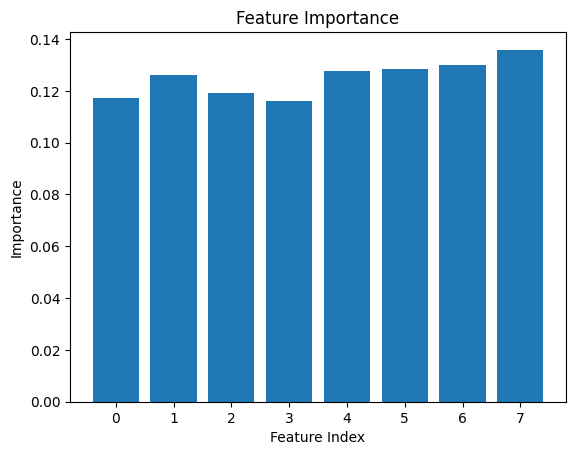

In [31]:
importances = clf.feature_importances_
print(importances)

# Visualize feature importance
import matplotlib.pyplot as plt
plt.bar(range(len(importances)), importances)
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()

This importance score tells me that Feature 7 (score of 0.135) contributed most to the ML models predictions while Feature 2 (score of 0.115) contributed the least.

In [34]:
# Following line gives runtime of 9.9s, accuracy of 0.2093
# clf = RandomForestClassifier(n_estimators=50, max_depth=10, n_jobs=2, random_state=42)

# Following gives a runtime of 28.2s, accuracy of 0.7490
clf = RandomForestClassifier(n_estimators=50, n_jobs=2, random_state=43)

#rs42: 0.74186
#rs43: 0.73698

top_n_features = 10
top_features_idx = importances.argsort()[-top_n_features:]
X_train_reduced = X_train[:, top_features_idx]
X_test_reduced = X_test[:, top_features_idx]

# Re-train on reduced feature set
clf.fit(X_train_reduced, y_train)

RandomForestClassifier(n_estimators=50, n_jobs=2, random_state=43)

In [35]:
y_pred = clf.predict(X_test_reduced)
print(f"Accuracy with reduced features: {accuracy_score(y_test, y_pred)}")

Accuracy with reduced features: 0.7369791666666666
